# CPC Speech usage examples

## Extract speech embeddings

In [74]:
from cpcspeech.cpcspeech import CPC_speech
import h5py
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [75]:
data_path = '/path/to/data'

sample_data = h5py.File(data_path, 'r')
seq_len = 20480
X = np.array([sample_data[k][:seq_len] for k in list(sample_data.keys())])
X = X[:,np.newaxis,:]

In [76]:
model_path = '/path/to/trained/model'
cpc = CPC_speech()
cpc.load_pretrained_model(model_path)

In [ ]:
speech_emb = cpc.transform(X)

In [ ]:
tsne_spk_emb = TSNE(n_components=2).fit_transform(speech_emb)
plt.scatter(tsne_spk_emb[:,0],tsne_spk_emb[:,1])

## Preprocess dataset

In [8]:
import sys
from cpcspeech.data import LibriSpeech100_preprocessing

In [11]:
data_path = '/path/to/librispeech/dataset/raw'
split_path = '/path/to/labels/split'
processed_data_path = '/path/to/librispeech/dataset/processed'
seq_len = 20480

train_file_list_path = split_path+'train_split.txt'
valid_file_list_path = split_path+'valid_split.txt'
valid_file_list_path = split_path+'test_split.txt'

train_output_path = processed_data_path+'librispeech_train.hdf5'
valid_output_path = processed_data_path+'librispeech_valid.hdf5'
test_output_path  = processed_data_path+'librispeech_test.hdf5'

In [ ]:
LibriSpeech100_preprocessing(train_file_list_path, data_path, train_output_path, seq_len)
LibriSpeech100_preprocessing(valid_file_list_path, data_path, valid_output_path, seq_len)
LibriSpeech100_preprocessing(test_file_list_path, data_path, test_output_path, seq_len)

## CPC training

In [2]:
from cpcspeech.cpcspeech import CPC_speech

In [3]:
cpc = CPC_speech(gpu=True)

In [4]:
train_path = '/path/to/librispeech/dataset/processed/train'
valid_path = '/path/to/librispeech/dataset/processed/valid'

cpc.load_train_data(train_path, valid_path)

In [73]:
cpc.train(100,plot=False)

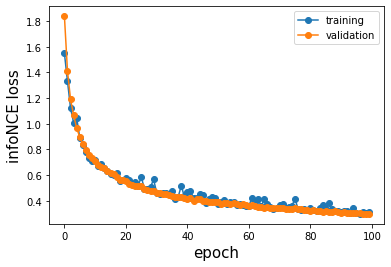

In [15]:
plt.plot([l.item() for l in cpc.training.train_loss_hist],'-o',label='training')
plt.plot([l.item() for l in cpc.training.valid_loss_hist],'-o',label='validation')
plt.ylabel('infoNCE loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.legend()

In [18]:
save_model_folder = '../trained_models/'
cpc.save_model(save_model_folder)

## Speaker classification with CPC embeddings

In [19]:
from cpcspeech.models import MLP
from cpcspeech.cpcspeech import CPC_speech
from cpcspeech.data import LibriSpeech100_dataset_spk_class
from cpcspeech.train import Spk_Training

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [20]:
device_type = 'cuda' #'cpu'
device = torch.device(device_type)

### load dataset

In [21]:
train_path = '/path/to/librispeech/dataset/processed/train'
valid_path = '/path/to/librispeech/dataset/processed/valid'
test_path = '/path/to/librispeech/dataset/processed/test'

In [22]:
seq_len = 20480
batch_size = 64

train_spk_data = LibriSpeech100_dataset_spk_class(train_path,seq_len,batch_size)
train_spk_dataloader = DataLoader(train_spk_data, batch_size=batch_size, shuffle=True, num_workers=0)

valid_spk_data = LibriSpeech100_dataset_spk_class(train_path,seq_len,batch_size)
valid_spk_dataloader = DataLoader(valid_spk_data, batch_size=batch_size, shuffle=True, num_workers=0)

test_spk_data = LibriSpeech100_dataset_spk_class(train_path,seq_len,batch_size)
test_spk_dataloader = DataLoader(valid_spk_data, batch_size=batch_size, shuffle=True, num_workers=0)

### load and freeze CPC model

In [24]:
model_path = '/path/to/trained/model'

In [25]:
cpc = CPC_speech(gpu=True)
cpc.load_pretrained_model(model_path)
cpc.freeze()
cpc_model = cpc.cpc_model

### initialize MLP speaker model

In [27]:
n_speakers = len(train_spk_data.unique_spk_ids)
emb_size = 256
inner_size = 512
spk_classifier = MLP(emb_size, inner_size, n_speakers).to(device)

### train

In [28]:
train_params = [p for p in spk_classifier.parameters() if p.requires_grad == True]
optimizer = optim.Adam(train_params, lr=0.0002, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
loss = F.nll_loss

In [1]:
n_epochs = 100
spk_training = Spk_Training(cpc_model, spk_classifier, loss, optimizer, device)
spk_training.train(train_spk_dataloader, valid_spk_dataloader, n_epochs, plot=False)

In [30]:
test_loss, test_acc = spk_training.validation_epoch(test_spk_dataloader)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

test loss:  0.16810425608827356
test acc:  0.9575109649122807


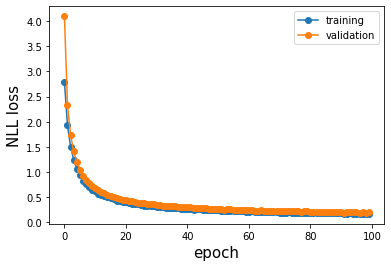

In [36]:
import matplotlib.pyplot as plt
plt.plot(spk_training.train_loss_hist,'-o',label='training')
plt.plot(spk_training.valid_loss_hist,'-o',label='validation')
plt.ylabel('NLL loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.legend()